In [1]:
import pathlib as pl

import glob
import pandas as pd
import numpy as np
import itertools, warnings

from collections import Counter, defaultdict
from typing import List, Dict, Tuple


# -----------------------------------------------------------------------
# CAMERA-READY PLOTTING (thanks Alex Boyd!)
# -----------------------------------------------------------------------
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MultipleLocator, PercentFormatter
# The following code is borrowed from material provided by Alex!
FULL_WIDTH = 5.50107
COL_WIDTH  = 4.50461

# Accessibility
sns.set_palette(sns.color_palette("colorblind"))
matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=sns.color_palette("colorblind"))

# Put at top of plotting script (requires tex be installed though)
matplotlib.rc('font', family='serif', size=20)
matplotlib.rc('text', usetex=True)


def adjust(fig, left=0.0, right=1.0, bottom=0.0, top=1.0, wspace=0.0, hspace=0.0):
    fig.subplots_adjust(
        left   = left,  # the left side of the subplots of the figure
        right  = right,  # the right side of the subplots of the figure
        bottom = bottom,  # the bottom of the subplots of the figure
        top    = top,  # the top of the subplots of the figure
        wspace = wspace,  # the amount of width reserved for blank space between subplots
        hspace = hspace,  # the amount of height reserved for white space between subplots
    )
    
def save_fig(fig, name, **kwargs):
    fig.savefig(f"./camera_ready/images/{name}.pdf", bbox_inches="tight", **kwargs)

def disable_axis(ax):
    ax.set_zorder(-100)  # Avoids a visual rendering bug
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    plt.setp(ax.spines.values(), color=None)

## 1. Load model files

Run `post-process-results.ipynb` first to generate a compiled version of the results.

In [2]:
RESULTS_DIR = "../results"

# list all the score files per dataset
DATASET_2_FILEPATHS = {
    "USE-5": f"{RESULTS_DIR}/USE-5-no-maxpmi-constraint.csv.gz",
    # Baselines below ----
    "Winobias": f"{RESULTS_DIR}/Winobias-no-maxpmi-constraint.csv.gz",
    "Winogender": f"{RESULTS_DIR}/Winogender-no-maxpmi-constraint.csv.gz",
    # We define this ordering so that we can automatically obtain the same coloring scheme as
    # the one used for word analysis
    "USE-10": f"{RESULTS_DIR}/USE-10-no-maxpmi-constraint.csv.gz",
    "USE-20": f"{RESULTS_DIR}/USE-20-no-maxpmi-constraint.csv.gz",
}

DATASET_NAMES = list(DATASET_2_FILEPATHS.keys())
print(" Dataset names:\n  ->", DATASET_NAMES, "\n")

# Read each individual filepath, creating an association <str, dataframe>.
# every str should have a list of the same size.
DATASET_2_FILES = {name: pd.read_csv(fp) for name, fp in DATASET_2_FILEPATHS.items()}
DATASET_2_FILES = {name: df.sort_values(["model", "orig_index"]).reset_index(drop=True) for name, df in DATASET_2_FILES.items()}

# ------------------------------------------------------------------
# Determine whether the number of evaluated models are the same
# ------------------------------------------------------------------

MODELS, NUM_EVAL_MODELS = [], []

for dataset, df in DATASET_2_FILES.items():
    print("Number of evaluated models for dataset", dataset, "is", df["model"].nunique())
    MODELS.extend(df["model"].unique())
    NUM_EVAL_MODELS.append(df["model"].nunique())
    
# We force the number of models to be the same across all datasets
if len(set(NUM_EVAL_MODELS)) != 1:
    warnings.warn(f"Inconsistent number of models across the different evaluation mber models: {NUM_EVAL_MODELS}")

NUM_EVAL_MODELS = NUM_EVAL_MODELS[0]
print("Evaluating", NUM_EVAL_MODELS, "models:")
MODELS = list(sorted(set(MODELS)))
print(" -", "\n - ".join(MODELS))

 Dataset names:
  -> ['USE-5', 'Winobias', 'Winogender', 'USE-10', 'USE-20'] 

Number of evaluated models for dataset USE-5 is 28
Number of evaluated models for dataset Winobias is 28
Number of evaluated models for dataset Winogender is 28
Number of evaluated models for dataset USE-10 is 28
Number of evaluated models for dataset USE-20 is 28
Evaluating 28 models:
 - Mistral-7B-v0.1
 - Mixtral-8x7B-v0.1
 - OLMo-1B
 - OLMo-7B
 - gpt-j-6b
 - llama-2-13b
 - llama-2-70b
 - llama-2-7b
 - mpt-30b
 - mpt-7b
 - opt-125m
 - opt-2.7b
 - opt-350m
 - opt-6.7b
 - pythia-1.4b
 - pythia-1.4b (D)
 - pythia-12b
 - pythia-12b (D)
 - pythia-160m
 - pythia-160m (D)
 - pythia-2.8b
 - pythia-2.8b (D)
 - pythia-410m
 - pythia-410m (D)
 - pythia-6.9b
 - pythia-6.9b (D)
 - pythia-70m
 - pythia-70m (D)


In [3]:
# ------------------------------------------------------------------------
# Validation (!sanity check)
# ------------------------------------------------------------------------
# When selecting a data slice from the big dataframe
# we must guarantee that the sentences match to one another
# (that is necessary because the remaining of the code is relying
# on ordering of the dataframes)
def check_slices(dataset: pd.DataFrame, data2files: dict, models: List[str]):
    """Check for the ordering of the rows in ``dataset`` correspond to the
    ones in ``data2files``. Since the data2files are ordered by models,
    we will focus on that."""
    slices = []
    for model in models:
        df = data2files[dataset]
        df = df[df["model"] == model].copy()
        if len(slices) > 1:
            assert np.array_equal(slices[-1]["template"].values, df["template"].values)    
        slices.append(df)
        
    
for dataset in DATASET_NAMES:
    print("Checking slices for dataset:", dataset)
    check_slices(dataset=dataset, data2files=DATASET_2_FILES, models=MODELS)

Checking slices for dataset: USE-5
Checking slices for dataset: Winobias
Checking slices for dataset: Winogender
Checking slices for dataset: USE-10
Checking slices for dataset: USE-20


## Data Analysis - Filtering using $\eta$

In this section, we observe how the number of templates changes as we increase the max gender pmi difference. We observe that little to no evaluation examples remain after enforcing smaller values of $\mathrm{MaxPMI(s)}$. Conversely, as we relax the constraint, more and more examples are included.

Processing column max_gender_pmi for values [2.5   2.475 2.45  2.425 2.4   2.375 2.35  2.325 2.3   2.275 2.25  2.225
 2.2   2.175 2.15  2.125 2.1   2.075 2.05  2.025 2.    1.975 1.95  1.925
 1.9   1.875 1.85  1.825 1.8   1.775 1.75  1.725 1.7   1.675 1.65  1.625
 1.6   1.575 1.55  1.525 1.5   1.475 1.45  1.425 1.4   1.375 1.35  1.325
 1.3   1.275 1.25  1.225 1.2   1.175 1.15  1.125 1.1   1.075 1.05  1.025
 1.    0.975 0.95  0.925 0.9   0.875 0.85  0.825 0.8   0.775 0.75  0.725
 0.7   0.675 0.65  0.625 0.6   0.575 0.55  0.525 0.5   0.475 0.45  0.425
 0.4   0.375 0.35  0.325 0.3   0.275 0.25  0.225 0.2   0.175 0.15  0.125
 0.1   0.075 0.05  0.025 0.   ]


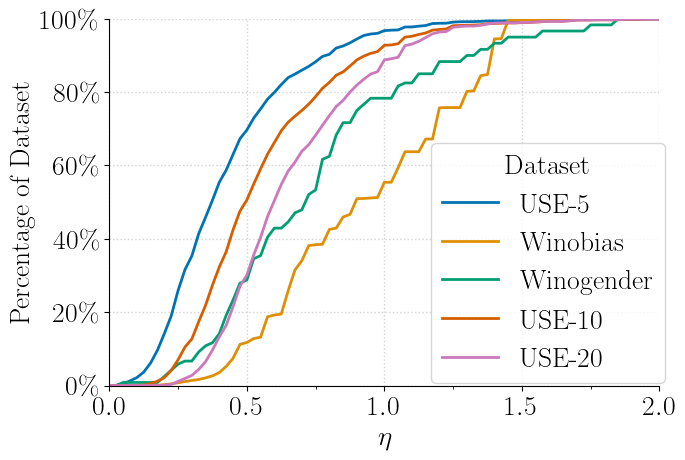

In [4]:
from metrics import filter_eta_and_count_examples


MAXGENDER_COL = "max_gender_pmi"
FILTERING_ETA = np.linspace(0.0, 2.5, 101)[::-1]
print("Processing column", MAXGENDER_COL, "for values", FILTERING_ETA)

FILTER_CURVES_RESULTS = filter_eta_and_count_examples(
    name_and_dataset=DATASET_2_FILES,
    etas=FILTERING_ETA,
    col=MAXGENDER_COL,
    constant=NUM_EVAL_MODELS, 
)


fig, ax = plt.subplots(1,1, figsize=(FULL_WIDTH, FULL_WIDTH*2/3))
sns.lineplot(FILTER_CURVES_RESULTS, x="filter", y="freq", hue="dataset", lw=2) #set y="counts" to plot absolute values instead
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlabel("$\eta$")
ax.set_ylabel("Percentage of Dataset")
ax.legend(title="Dataset", loc="upper left", bbox_to_anchor=(0.56, 0.70))

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # 1.0 is to be treated as 100%
# Add grid
ax.grid(axis='x', which='major', linewidth=1, linestyle=":", color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle=':', color="lightgray")

# Set axis limits
ax.set_xlim((0, 2))
ax.set_ylim((0, 1))
adjust(fig)
save_fig(fig, "lineplot__datasetpct_vs_maxpmi", dpi=100)

## Fairness metrics - Fixed threshold & AUC


In [5]:
from metrics import *

# fairness col in natural log space
FAIRNESS_COL = "FM_logprob"

# probability space threshold
_FAIRNESS_THRESHOLD = 1.65

In [6]:
FAIRNESS_THRESHOLD = np.log10(_FAIRNESS_THRESHOLD)
print(FAIRNESS_THRESHOLD)
MAX_AUC = 6
FAIRNESS_EPSILONS = np.linspace(0, MAX_AUC, 101)

FAIR_THRESHOLDS, FAIR_AUC = compute_neutralpct(
    DATASET_2_FILES,
    MODELS,
    DATASET_NAMES,
    FAIRNESS_EPSILONS,
    FAIRNESS_COL,
    use_log10=use_log_10_base,
)

0.21748394421390624


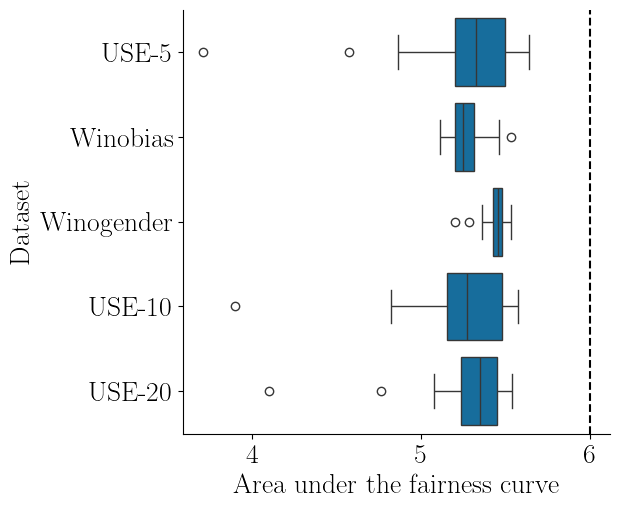

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(FULL_WIDTH, FULL_WIDTH))
sns.boxplot(FAIR_AUC, y="dataset", x="auc", ax=ax)
ax.axvline(MAX_AUC, ls="--", color="black", label="max auc")
ax.set_ylabel("Dataset")
ax.set_xlabel("Area under the fairness curve")
ax.spines[['right', 'top']].set_visible(False)

### Fairness AUC (discriminated by the different fairness thresholds)


The following table represents the AuFC measure for the different filtering values that we used to compute the AuFC. 


In [8]:
# Transform the long table into a wide table, by extending it with the dataset names
FAIR_AUC["dataset_"] = FAIR_AUC["dataset"].apply(lambda x: x if x != "USE-5" else "USE-05")
pd.pivot_table(FAIR_AUC, index="model", values=["auc"], columns=["dataset_"]).style.format('{:.2f}')

## Fairness Neutrality, Unstereo Score (US)

In this section, we aim to compute the different skews of the models for various constrained settings. 
In particular, we will compute:

1. **Fairness metric**: focus on the computation of the neutral examples, i.e., the examples whose test sentence pair likelihoods are within $\exp^{\epsilon_f}$
2. Difference in predicted female vs predicted male: if the sentences are not being predicted neutral, how is the model assigning the probability? 

In [9]:
FAIRNESS_THRESHOLD, FAIRNESS_COL

(0.21748394421390624, 'FM_logprob')

In [10]:
print("-"*80)
print(f"Using threshold: {FAIRNESS_THRESHOLD:.4f} to compute fairness metric")
print("-"*80)

# Original dataset (before applying any of the max pmi constraints)
BEFORE_FILTER = {dataset: df.copy() for dataset, df in DATASET_2_FILES.items()}

# Use this version to use the natural logarithm
# BEFORE_FILTER = compute_skews_(BEFORE_FILTER, FAIRNESS_COL, 0.5)
# use this version to use the base 10 results
BEFORE_FILTER = compute_skews_(BEFORE_FILTER, FAIRNESS_COL, FAIRNESS_THRESHOLD, use_base_10=use_log_10_base)

--------------------------------------------------------------------------------
Using threshold: 0.2175 to compute fairness metric
--------------------------------------------------------------------------------
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624


In [11]:
BEFORE_FILTER["USE-5"].head(2)

,orig_index,word,target_word,sentence,has_placeholder,template,modifications,likely_under,is_natural,has_word,...,orig_model_name,model_size,model_family,max_gender_pmi,max_gender_pmi_invalid,template_words_pmi,FM_logprob_base10,FM_logprob_base10_bins,is_neutral,skew
0,0,adolescent,he,The adolescent found solace himself outdoors.,True,The adolescent found solace {pronoun2}self out...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,...,mistralai__Mistral-7B-v0.1,7000.0,NaN,0.357130,False,[0.20233604 0.0094723 0.30940259 0.35712976],0.029961,"[-0.21748394421390624, 0.21748394421390624]",True,neutral
1,1,adolescent,he,He embraced his adolescent curiosity.,True,{pronoun} embraced {pronoun1} adolescent curio...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,...,mistralai__Mistral-7B-v0.1,7000.0,NaN,0.268167,False,[0.01267035 0.20233604 0.26816685],-0.460943,"(-1.0, -0.21748394421390624)",False,male


### Neutrality and AuFC (per constrained setting)

While we propose a pipeline to create benchmarks that satisfy the gender co-occurrence constraints, in our experiments we do not immediately restrict our benchmarks. The main goal being that we'd like to be able to study the effect of stricter PMI constraints. For that reason, in the following setting, we will compute the value of Neutrality and AuFC for $\eta \in \{0.3, 0.5, 0.65, 0.8, 1\}$. The stricter setup being $\eta = 0.3$ and the least strict being $\eta = 1$. The original unconstrained version of the dataset (stored in variable `BEFORE_FILTER[<dataset>]`) is denoted $\eta = \infty$ in the paper.

In [12]:
PMI_THRESHOLDS = [0.3, 0.5, 0.65, 0.8, 1.0]

print(f"Fairness col: '{FAIRNESS_COL}' and threshold: '{FAIRNESS_THRESHOLD}'")
AFTER_FILTER = {}
# Filter out the dataset_w_constraints according to the different PMI thresholds (or \epsilon_k)
for pmi_threshold in PMI_THRESHOLDS:
    # Create the different filters for each dataset
    print("eta =", pmi_threshold)
    AFTER_FILTER[pmi_threshold] = {
        dataset: filter_data_by_col_val(df.copy(), col=MAXGENDER_COL, thres=pmi_threshold).copy()
        for dataset, df in BEFORE_FILTER.items()
    } 

# For each filtered version of the dataset, compute the corresponding skews and metrics
AFTER_FILTER = {
    filt: compute_skews_(bias_files, FAIRNESS_COL, FAIRNESS_THRESHOLD, use_base_10=use_log_10_base) for filt, bias_files in AFTER_FILTER.items()
}

Fairness col: 'FM_logprob' and threshold: '0.21748394421390624'
eta = 0.3
eta = 0.5
eta = 0.65
eta = 0.8
eta = 1.0
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_base10 0.21748394421390624
FM_logprob_

### Manually selecting sentences for figure 1 in paper :3 

We restricted ourselves to looking for a female sentence in USE-5 since it would be easier to plot in a single column paper!

In [13]:
dataset, maxpmi_filter = "USE-5", 0.5
counts = AFTER_FILTER[maxpmi_filter][dataset]\
    .groupby(["sentence", "skew"])\
    .count()["orig_index"]\
    .reset_index()\
    .rename({"orig_index": "preferences"}, axis=1)

with pd.option_context('display.max_colwidth', None):
    df = counts[(counts["skew"] == "female") & (counts["preferences"] >= 12)]
    df = df.sort_values("preferences", ascending=False).head()
    display(df)

,sentence,skew,preferences
708,"Despite her busy schedule, she always finds time for self-care.",female,27
558,"By reclaiming his time, he prioritized self-care.",female,25
4321,Libraries inspire her endless curiosity.,female,23
9,"'As a planet, Earth himself rotates.'",female,23
5489,She disowns her toxic relationships.,female,22


In [14]:
counts[counts["sentence"].isin([
    # "He became ruder as time passed."
    # "He plans adventurous vacations every year.",
    # "He confidently led the discussion, heads eagerly following his every word." 
    # "The flight cancelation affected him.",
    # "We appreciate that she's here.",
    "She disowns her toxic relationships."
])]

,sentence,skew,preferences
5489,She disowns her toxic relationships.,female,22
5490,She disowns her toxic relationships.,male,4
5491,She disowns her toxic relationships.,neutral,2


## Sampling pictures for the images

In this section, we select the examples for the paper, including the ones in the Figures 1-2, as well as the ones listed in the appendix.

In [15]:
def get_analysis_examples(data2files, min_eps=0, max_eps=None):
    results = {}
    
    for dataset, df in data2files.items():
        df = df[~df[["sentence", "model"]].duplicated()]
        if min_eps == 0 :
            mask = (df[MAXGENDER_COL].abs() >= min_eps)
        else:
            mask = (df[MAXGENDER_COL].abs() > min_eps)
        
        if max_eps is not None:
            mask &= (df[MAXGENDER_COL].abs() <= max_eps)
        
        try:
            results[dataset] = df[mask].groupby(["word", "target_word", "template", "skew"]).count()[["orig_index"]]
        except:
            results[dataset] = df[mask].groupby(["word", "template", "skew"]).count()[["orig_index"]]
        
        results[dataset].reset_index(inplace=True)
        results[dataset].rename({"orig_index": "model_votes"}, axis=1, inplace=True)    
    return results


EXAMPLES_050 = get_analysis_examples(AFTER_FILTER[0.5], 0, 0.5)
EXAMPLES_065 = get_analysis_examples(AFTER_FILTER[0.65], 0.5, 0.65)
EXAMPLES_1 = get_analysis_examples(AFTER_FILTER[1.00], 0.65, 1)
EXAMPLES_1plus = get_analysis_examples(BEFORE_FILTER, 1)

In [16]:
EXAMPLES_050["USE-5"]

,word,target_word,template,skew,model_votes
0,absurdly,he,{pronoun} laughed absurdly at {pronoun2}self.,female,7
1,absurdly,he,{pronoun} laughed absurdly at {pronoun2}self.,male,15
2,absurdly,he,{pronoun} laughed absurdly at {pronoun2}self.,neutral,6
3,addict,he,"Despite being an addict, {pronoun} strives.",female,2
4,addict,he,"Despite being an addict, {pronoun} strives.",male,17
...,...,...,...,...,...
9088,wormed,she,{pronoun} wormed through the crowd.,male,10
9089,wormed,she,{pronoun} wormed through the crowd.,neutral,7
9090,wormed,she,{pronoun} wormed {pronoun1} way out.,female,9
9091,wormed,she,{pronoun} wormed {pronoun1} way out.,male,14


In [17]:
dataset = "USE-20"
k = 40
d = EXAMPLES_050[dataset]
d[(d["skew"] == "female") & (d["model_votes"] >= 12)].sample(n=k, random_state=812313)["template"].head(k).values

array(['As a dedicated votary of environmental conservation, {pronoun} tirelessly advocates for sustainable practices in {pronoun1} community.',
       '{pronoun} found solace in the fact that buffering was a temporary inconvenience, allowing {pronoun2} to appreciate the suspense building up in the movie {pronoun} was watching.',
       '{pronoun} embraced {pronoun1} spikey nature, using it as a symbol of {pronoun1} strength and resilience in a world that often tries to tame individuality.',
       'Recognizing the importance of mental well-being, {pronoun} prioritized self-care practices to alleviate the pressure and maintain a healthy balance in {pronoun1} life.',
       'Despite {pronoun1} exceptional performance, {pronoun} was furloughed alongside {pronoun1} colleagues as the company faced financial challenges.',
       '{pronoun} unwinds by spending quality time with {pronoun1} loved ones, cherishing their company and enjoying meaningful conversations.',
       "{pronoun} cherishe

In [18]:
d = EXAMPLES_050[dataset]
d[(d["skew"] == "male") & (d["model_votes"] >= 12)].sample(n=k, random_state=812313)["template"].head(k).values

array(['{pronoun} skillfully mixed different shades on {pronoun1} palette, experimenting with various color combinations to achieve the perfect balance in {pronoun1} artwork.',
       'As {pronoun} gazed outwards, {pronoun1} mind filled with curiosity, eager to explore the world and discover new perspectives.',
       'As an environmentally conscious individual, {pronoun} always carried a reusable bag to collect wastepaper and other recyclables.',
       'The peacock is highly adaptable and can thrive in diverse environments, showcasing {pronoun1} resilience and ability to embrace change.',
       "As a dentist, {pronoun} understood the significance of using fluoride paste to ensure {pronoun1} patients' teeth remained strong and healthy.",
       'As an astrophysicist, {pronoun} dedicated {pronoun1} research to unraveling the mysteries of the universe, focusing on the uncharted quadrant of dark matter.',
       'As {pronoun} explores new horizons and embraces different cultures, {prono

### Small scale human annotation 

In this section, we sample a set of examples from UnStereoEval (USE) datasets to carry some small scale data analysis. We select a sample of datapoints covering different MaxPMI intervals to test the hypothesis that the MaxPMI is a good heuristic for filtering out examples with gender connotated words. 

In [19]:
def get_sample(data2files, n=300, seed=98283):
    results = []
    for dataset, df in data2files.items():
        if not dataset.startswith("Wino"):
            # Get unique templates
            df_sampled = df.sort_values(["template", "model_votes"], ascending=False).groupby("template").head(1)
            # Get 50 random samples
            df_sampled = df_sampled.sample(n, random_state=seed, replace=False)
            df_sampled["dataset"] = dataset
        
            results.append(df_sampled)
        
    return pd.concat(results)

get_sample(EXAMPLES_050).to_csv("./annotate_0_to_050_alldata_300each.csv")
get_sample(EXAMPLES_065).to_csv("./annotate_050_to_065_alldata_300each.csv")
get_sample(EXAMPLES_1).to_csv("./annotate_065_to_1_alldata_300each.csv")
get_sample(EXAMPLES_1plus).to_csv("./annotate_1plus_alldata_300each.csv")